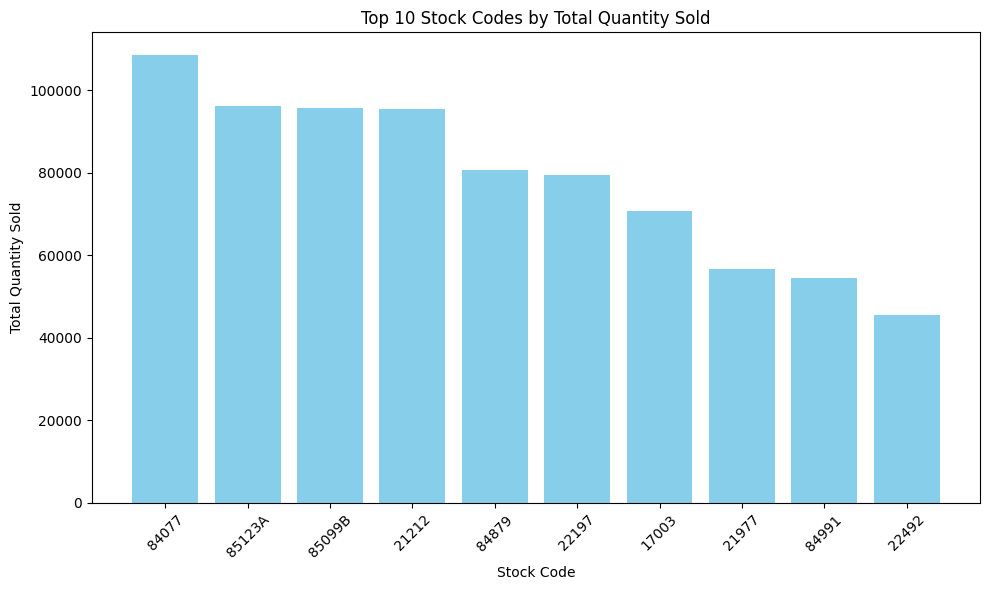

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the transactional data
transactional_data_1 = pd.read_csv('Transactional_data_retail_01.csv')
transactional_data_2 = pd.read_csv('Transactional_data_retail_02.csv')

# Concatenate the two transactional datasets
transactional_data = pd.concat([transactional_data_1, transactional_data_2])



# Group by StockCode and sum the Quantity sold
top_stock_codes = transactional_data.groupby('StockCode')['Quantity'].sum().reset_index()

# Sort by Quantity in descending order and get the top 10
top_10_stock_codes = top_stock_codes.sort_values(by='Quantity', ascending=False).head(10)

# Plot the top 10 stock codes
plt.figure(figsize=(10, 6))
plt.bar(top_10_stock_codes['StockCode'], top_10_stock_codes['Quantity'], color='skyblue')
plt.xlabel('Stock Code')
plt.ylabel('Total Quantity Sold')
plt.title('Top 10 Stock Codes by Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


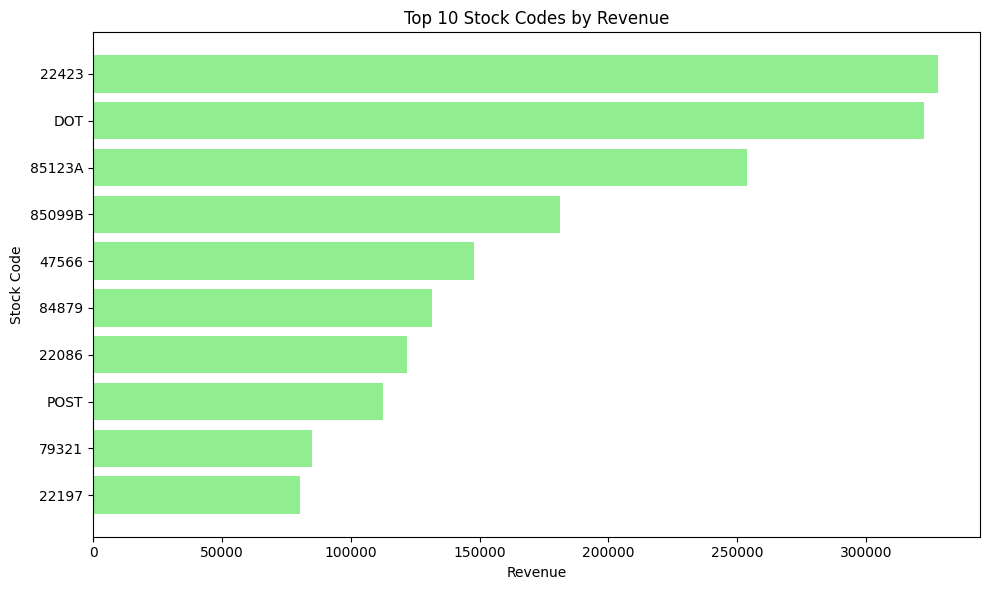

In [ ]:
# Calculate revenue for each transaction (Quantity * Price)
transactional_data['Revenue'] = transactional_data['Quantity'] * transactional_data['Price']

# Group by StockCode and sum the Revenue
top_revenue_products = transactional_data.groupby('StockCode')['Revenue'].sum().reset_index()

# Sort by Revenue in descending order and get the top 10
top_10_revenue_products = top_revenue_products.sort_values(by='Revenue', ascending=False).head(10)

# Plot the top 10 revenue-generating products by StockCode
plt.figure(figsize=(10, 6))
plt.barh(top_10_revenue_products['StockCode'], top_10_revenue_products['Revenue'], color='lightgreen')
plt.xlabel('Revenue')
plt.ylabel('Stock Code')
plt.title('Top 10 Stock Codes by Revenue')
plt.gca().invert_yaxis()  # To display the highest revenue at the top
plt.tight_layout()
plt.show()

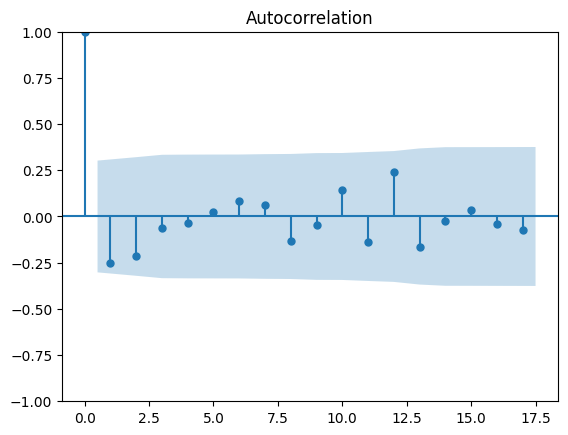

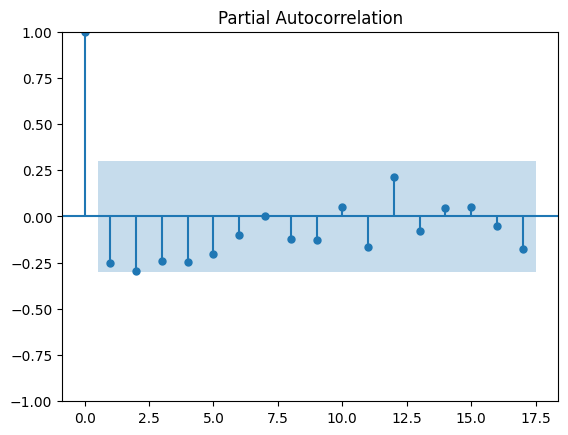

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
data = transactional_data
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')
data.dropna(subset=['InvoiceDate', 'Quantity', 'Price'], inplace=True)
data.set_index('InvoiceDate', inplace=True)

# Group by StockCode and resample weekly
top_products = data.groupby('StockCode')['Quantity'].sum().nlargest(10).index
ts_data = data[data['StockCode'].isin(top_products)].groupby([pd.Grouper(freq='W'), 'StockCode'])['Quantity'].sum().unstack()

# Split data into train (80%) and test (20%)
train_size = int(len(ts_data) * 0.8)
train_data, test_data = ts_data[:train_size], ts_data[train_size:]

# Plot ACF and PACF for one of the top products
product_code = top_products[0]  # Example for first product
plot_acf(train_data[product_code])
plt.show()
plot_pacf(train_data[product_code])
plt.show()

# Define a function to calculate evaluation metrics
def evaluate_forecast(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    return rmse, mae

# ARIMA Model for one product
arima_model = ARIMA(train_data[product_code], order=(15,2,0))
arima_fit = arima_model.fit()
forecast_arima = arima_fit.forecast(steps=len(test_data))

In [ ]:
# Evaluate each model and plot actual vs forecast
def plot_forecasts(test, forecast, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Actual', color='blue')
    plt.plot(test.index[:len(forecast)], forecast, label=f'{model_name} Forecast', color='red')
    plt.title(f'Actual vs {model_name} Forecast')
    plt.legend()
    plt.show()

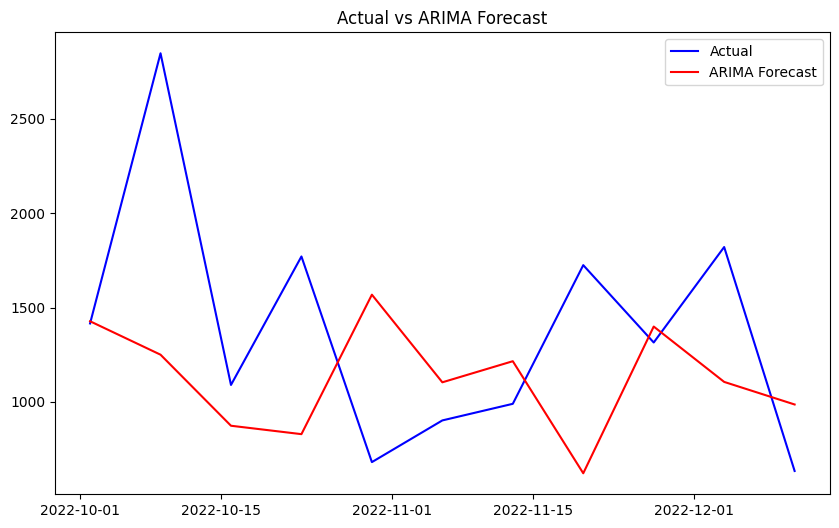

In [ ]:
# Plot ARIMA
plot_forecasts(test_data[product_code], forecast_arima, 'ARIMA')

In [ ]:
# ETS (Exponential Smoothing) Model with adjustments
try:
    ets_model = ExponentialSmoothing(train_data[product_code], trend='add', seasonal='add', seasonal_periods=12)
except ValueError as e:
    print(f"Error with ETS for {product_code}: {e}. Using non-seasonal ETS instead.")
    ets_model = ExponentialSmoothing(train_data[product_code], trend='add', seasonal=None)

ets_fit = ets_model.fit()
forecast_ets = ets_fit.forecast(steps=len(test_data))

# Prophet Model
prophet_df = train_data[[product_code]].reset_index().rename(columns={'InvoiceDate': 'ds', product_code: 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
forecast_prophet = prophet_model.predict(future)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run p

In [ ]:
# LSTM Model
lstm_data = train_data[product_code].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(lstm_data)

# Prepare data for LSTM model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train_scaled, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define and train LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

# Prepare test data for LSTM
test_lstm_data = test_data[product_code].values.reshape(-1, 1)
test_scaled = scaler.transform(test_lstm_data)
X_test, Y_test = create_dataset(test_scaled, look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict using LSTM
lstm_predict = lstm_model.predict(X_test)
lstm_predict = scaler.inverse_transform(lstm_predict)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
40/40 - 2s - 59ms/step - loss: 0.0863
Epoch 2/20
40/40 - 1s - 30ms/step - loss: 0.0561
Epoch 3/20
40/40 - 0s - 8ms/step - loss: 0.0486
Epoch 4/20
40/40 - 0s - 7ms/step - loss: 0.0456
Epoch 5/20
40/40 - 0s - 8ms/step - loss: 0.0439
Epoch 6/20
40/40 - 0s - 4ms/step - loss: 0.0428
Epoch 7/20
40/40 - 0s - 4ms/step - loss: 0.0418
Epoch 8/20
40/40 - 0s - 4ms/step - loss: 0.0414
Epoch 9/20
40/40 - 0s - 4ms/step - loss: 0.0403
Epoch 10/20
40/40 - 0s - 8ms/step - loss: 0.0398
Epoch 11/20
40/40 - 0s - 4ms/step - loss: 0.0395
Epoch 12/20
40/40 - 0s - 6ms/step - loss: 0.0392
Epoch 13/20
40/40 - 0s - 3ms/step - loss: 0.0402
Epoch 14/20
40/40 - 0s - 4ms/step - loss: 0.0392
Epoch 15/20
40/40 - 0s - 3ms/step - loss: 0.0382
Epoch 16/20
40/40 - 0s - 3ms/step - loss: 0.0389
Epoch 17/20
40/40 - 0s - 3ms/step - loss: 0.0385
Epoch 18/20
40/40 - 0s - 3ms/step - loss: 0.0386
Epoch 19/20
40/40 - 0s - 3ms/step - loss: 0.0381
Epoch 20/20
40/40 - 0s - 3ms/step - loss: 0.0382
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

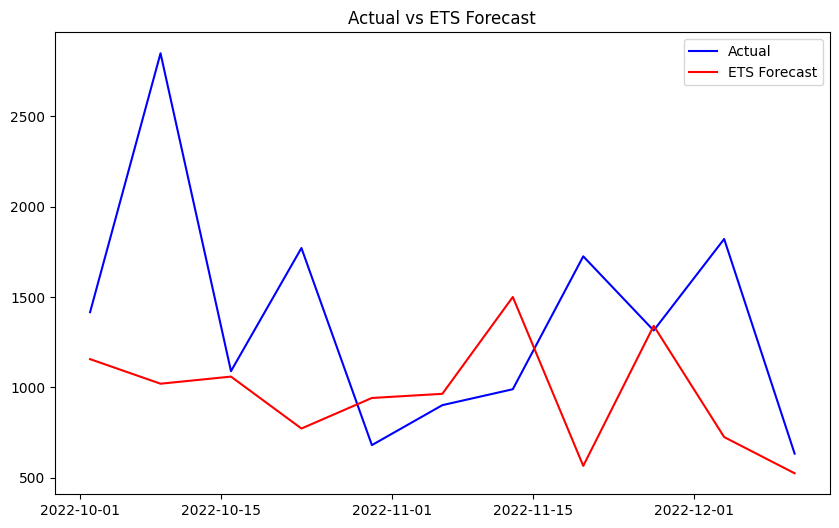

In [ ]:
# Plot ETS
plot_forecasts(test_data[product_code], forecast_ets, 'ETS')

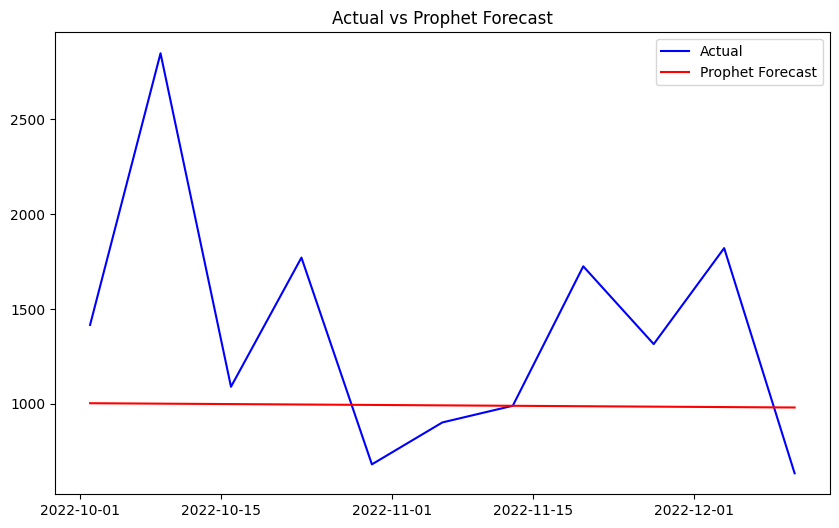

In [ ]:
# Plot Prophet
plot_forecasts(test_data[product_code], forecast_prophet['yhat'][-len(test_data):], 'Prophet')

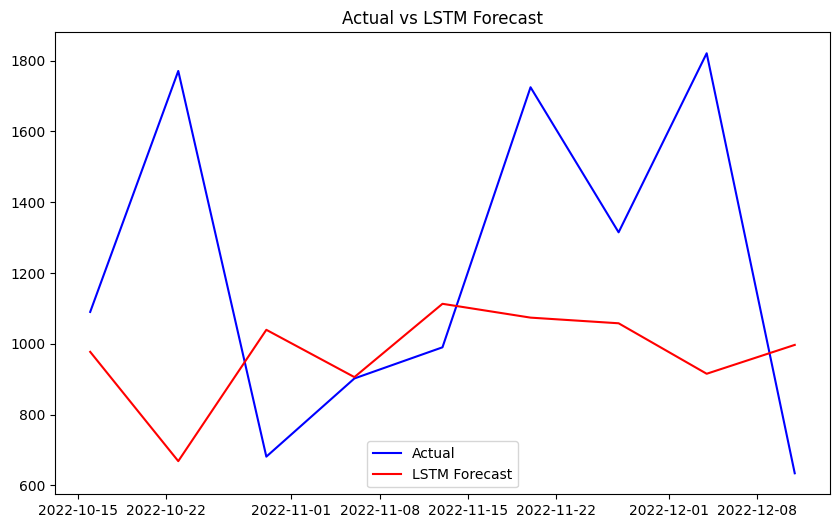

In [ ]:
# Plot LSTM
plot_forecasts(test_data[product_code][-len(lstm_predict):], lstm_predict, 'LSTM')

In [ ]:
# Evaluate each model
rmse_arima, mae_arima = evaluate_forecast(test_data[product_code], forecast_arima)
rmse_ets, mae_ets = evaluate_forecast(test_data[product_code], forecast_ets)
rmse_prophet, mae_prophet = evaluate_forecast(test_data[product_code], forecast_prophet['yhat'][-len(test_data):])
rmse_lstm, mae_lstm = evaluate_forecast(test_data[product_code][-len(lstm_predict):], lstm_predict)

print(f"ARIMA RMSE: {rmse_arima}, MAE: {mae_arima}")
print(f"ETS RMSE: {rmse_ets}, MAE: {mae_ets}")
print(f"Prophet RMSE: {rmse_prophet}, MAE: {mae_prophet}")
print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")

ARIMA RMSE: 812.7756378854303, MAE: 576.8031234752758
ETS RMSE: 814.1905601551408, MAE: 576.1390887678058
Prophet RMSE: 724.3207023190497, MAE: 525.5322197159377
LSTM RMSE: 559.1933754346684, MAE: 430.8285725911458


In [ ]:
# Non-Time Series Techniques (Decision Tree and XGBoost)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# For non-time series analysis, we'll use features like StockCode, Customer Demographics, etc.
customer_data = pd.read_csv('CustomerDemographics.csv')
product_data = pd.read_csv('ProductInfo.csv')

# Merge with transactional data
full_data = pd.merge(data.reset_index(), customer_data, on='Customer ID', how='left')
full_data = pd.merge(full_data, product_data, on='StockCode', how='left')

# Features for prediction (e.g., customer demographics, product features)
X = full_data[['Price']]
y = full_data['Quantity']

# Train-test split
X_train_non_ts, X_test_non_ts, y_train_non_ts, y_test_non_ts = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Model
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_non_ts, y_train_non_ts)
y_pred_tree = tree_model.predict(X_test_non_ts)

# XGBoost Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train_non_ts, y_train_non_ts)
y_pred_xgb = xgb_model.predict(X_test_non_ts)

# Evaluate Decision Tree and XGBoost models
rmse_tree, mae_tree = evaluate_forecast(y_test_non_ts, y_pred_tree)
rmse_xgb, mae_xgb = evaluate_forecast(y_test_non_ts, y_pred_xgb)

print(f"Decision Tree RMSE: {rmse_tree}, MAE: {mae_tree}")
print(f"XGBoost RMSE: {rmse_xgb}, MAE: {mae_xgb}")

Decision Tree RMSE: 92.10811299770361, MAE: 10.874070148556074
XGBoost RMSE: 91.39311100910852, MAE: 11.714767230308043
